In [21]:
from models.q_network import CardFeaturizer
import torch as t
from game.utils import variable
import numpy as np
from game.game_utils import Card, cards_to_array
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from IPython import display

# Load dataset

In [25]:
import pickle
filenames = ['hand_eval_51511071691.158362.p', 'hand_eval_2.p', 'hand_eval_51511068091.1125414.p', 'hand_eval_51511075291.2004554.p']
for filename in filenames:
    with open(filename, 'rb') as f:
        dataset_ = pickle.load(f)
        try:
            for k,v in dataset_.items():
                train_dataset[k] = v
        except:
            train_dataset = dataset_


In [27]:
import pickle
filenames = ['hand_eval_51511089691.300083.p']
for filename in filenames:
    with open(filename, 'rb') as f:
        dataset_ = pickle.load(f)
        try:
            for k,v in dataset_.items():
                test_dataset[k] = v
        except:
            test_dataset = dataset_


In [28]:
len(train_dataset), len(test_dataset)

(227456, 54652)

# Parse dataset

frozenset({'2d', '6c', '9d', '7s'})): {'player1winprob': 0.15217391304347827, 'High Card': 0.5217391304347826, 'Pair': 0.391304347826087, 'Two Pair': 0.0, 'Three of a Kind': 0.0, 'Straight': 0.08695652173913043, 'Flush': 0.0, 'Full House': 0.0, 'Four of a Kind': 0.0, 'Straight Flush': 0.0, 'Royal Flush': 0.0}}
Time diff is 0.002004861831665039

In [30]:
def parse_dataset(dataset):
    x_hand = np.zeros((len(dataset), 13, 4))
    x_board = np.zeros((len(dataset), 3, 13, 4))
    y = np.zeros((len(dataset), 10))

    for i, (cards_, probas) in enumerate(dataset.items()):
        # if there are only two cards and nothing on the board then the keys don't have the same format.....
        if isinstance(cards_, tuple):
            hand_, board_ = cards_
        else:
            hand_ = cards_
            board_ = None

        hand = []
        board = []

        for card_ in hand_:
            if card_[0] != 'T':
                try:
                    hand.append(Card(card_[0], card_[1]))
                except:
                    print(hand_, board_)
                    raise Exception
            else:
                hand.append(Card('10', card_[1]))

        if board_ is not None:
            for card_ in board_:
                if card_[0] != 'T':
                    board.append(Card(card_[0], card_[1]))
                else:
                    board.append(Card('10', card_[1]))

        x_hand[i] = cards_to_array(hand)
        x_board[i] = cards_to_array(board)
        y[i][0] = probas['player1winprob']
        y[i][1] = probas['High Card']
        y[i][2] = probas['Pair']
        y[i][3] = probas['Two Pair']
        y[i][4] = probas['Three of a Kind']
        y[i][5] = probas['Straight']
        y[i][6] = probas['Flush']
        y[i][7] = probas['Full House']
        y[i][8] = probas['Four of a Kind']
        y[i][9] = probas['Straight Flush']
    return x_hand, x_board, y


In [31]:
x_hand_train, x_board_train, y_train = parse_dataset(train_dataset)
x_hand_test, x_board_test, y_test = parse_dataset(test_dataset)

# Train neural network

In [54]:
f = CardFeaturizer(50)

In [55]:
def moving_avg(x, window=50):
    return [np.mean(x[k:k+window]) for k in range(len(x)-window)]

epoch 3


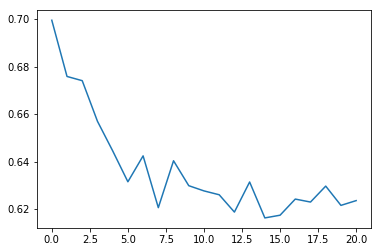

In [ ]:
lr = 1e-4
batch_size = 64
EPOCHS = 50
optimizer = t.optim.Adam(f.parameters(), lr=lr)
train_losses = []
test_losses = []
PLOT = 5000


for _ in range(EPOCHS):
    print('epoch', _)
    x_hand_train, x_board_train, y_train = shuffle(x_hand_train, x_board_train, y_train)
    for i in range(0, len(dataset), batch_size):
        hand = variable(x_hand_train[i:i+batch_size])
        board = variable(x_board_train[i:i+batch_size])
        target = variable(y_train[i:i+batch_size])
        
        optimizer.zero_grad()

        hand_strength, proba_combinations, flop_alone, turn_alone, river_alone, bh = f.forward(hand, board)
        
        loss = (-t.log(hand_strength.squeeze())*target[:, 0] - t.log(1-hand_strength.squeeze())*(1-target[:, 0]))
#         loss -= t.sum(t.log(proba_combinations)*target[:, 1:], -1)
        loss = t.sum(loss)
        
        train_losses.append(loss.data.numpy()[0]/batch_size)
        
        loss.backward()
        
        optimizer.step()
        
        if i % PLOT == 0:
            display.clear_output(wait=True)
            print('epoch', _)
            
            # test loss
            x_hand_test, x_board_test, y_test = shuffle(x_hand_test, x_board_test, y_test)
            hand = variable(x_hand_test[:1000])
            board = variable(x_board_test[:1000])
            target = variable(y_test[:1000])
            hand_strength, proba_combinations, flop_alone, turn_alone, river_alone, bh = f.forward(hand, board)
            loss = (-t.log(hand_strength.squeeze())*target[:, 0] - t.log(1-hand_strength.squeeze())*(1-target[:, 0]))
#             loss -= t.sum(t.log(proba_combinations)*target[:, 1:], -1)
            loss = t.sum(loss)
            test_losses.append(loss.data.numpy()[0]/1000)
            
            # plot
            plt.plot(test_losses)
            plt.show()
            plt.plot(moving_avg(train_losses))
            plt.show()